# First, download the data

In [1]:
import requests
import os
import gzip
import shutil

def download_file(url, filename):
    """
    Helper function to download a file from a URL and save it locally.
    """
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(filename, 'wb') as f:
            f.write(response.raw.read())
    else:
        print(f"Failed to download file: Status code {response.status_code}\nURL: {url}")

def decompress_gz(source_filepath, dest_filepath):
    """
    Decompresses a gzip file to a destination file path.
    """
    with gzip.open(source_filepath, 'rb') as f_in:
        with open(dest_filepath, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

os.makedirs("data", exist_ok=True)
data_dir = 'data/raw'  # Adjust the path according to your project structure
os.makedirs(data_dir, exist_ok=True)

# File URLs and paths
files = {
    'TPM_matrix': {
        'url': 'https://ftp.ncbi.nlm.nih.gov/geo/series/GSE75nnn/GSE75688/suppl/GSE75688_GEO_processed_Breast_Cancer_raw_TPM_matrix.txt.gz',
        'gz_path': 'GSE75688_GEO_processed_Breast_Cancer_raw_TPM_matrix.txt.gz',
        'final_path': 'GSE75688_GEO_processed_Breast_Cancer_raw_TPM_matrix.txt'
    },
    'sample_info': {
        'url': 'https://ftp.ncbi.nlm.nih.gov/geo/series/GSE75nnn/GSE75688/suppl/GSE75688_final_sample_information.txt.gz',
        'gz_path': 'GSE75688_final_sample_information.txt.gz',
        'final_path': 'GSE75688_final_sample_information.txt'
    }
}

for key, file_info in files.items():
    gz_file_path = os.path.join(data_dir, file_info['gz_path'])
    decompressed_file_path = os.path.join(data_dir, file_info['final_path'])

    # Download the file
    print(f"Downloading {key}...")
    download_file(file_info['url'], gz_file_path)

    # Decompress the file
    print(f"Decompressing {key}...")
    decompress_gz(gz_file_path, decompressed_file_path)

    print(f"{key} downloaded and decompressed successfully.")


Decompressing TPM_matrix...
TPM_matrix downloaded and decompressed successfully.
Decompressing sample_info...
sample_info downloaded and decompressed successfully.


# Data Preprocessing

In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler

def load_data(tpm_path, sample_info_path):
    """Load TPM matrix and sample information."""
    tpm_matrix = pd.read_csv(tpm_path, sep='\t', index_col=0)
    sample_info = pd.read_csv(sample_info_path, sep='\t', index_col=0)
    return tpm_matrix, sample_info

def preprocess_tpm_matrix(tpm_matrix):
    """Transpose TPM matrix and drop unnecessary initial rows."""
    tpm_transposed = tpm_matrix.T
    # Remove the first two rows which contain 'gene_name' and 'gene_type'
    tpm_transposed = tpm_transposed[2:] 
    return tpm_transposed

def map_subtypes(tpm_transposed):
    """Map samples to their subtypes."""
    subtype_mapping = {
        'BC01': 'ER+', 'BC02': 'ER+', 'BC03': 'ER+HER2+',
        'BC03LN': 'ER+HER2+ LN metastasis', 'BC04': 'HER2+',
        'BC05': 'HER2+', 'BC06': 'HER2+', 'BC07': 'TNBC',
        'BC07LN': 'TNBC LN metastasis', 'BC08': 'TNBC',
        'BC09': 'TNBC', 'BC10': 'TNBC', 'BC11': 'TNBC',
    }
    sample_subtypes = {sample: subtype_mapping[sample.split('_')[0]] for sample in tpm_transposed.index}
    tpm_transposed['subtype'] = pd.Series(sample_subtypes)
    return tpm_transposed

def prepare_data(tpm_transposed):
    """Prepare data for training."""
    X = tpm_transposed.drop('subtype', axis=1)
    y = tpm_transposed['subtype']
    
    # Scaling features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, y

# File paths
tpm_path = '../data/raw/GSE75688_GEO_processed_Breast_Cancer_raw_TPM_matrix.txt'
sample_info_path = '../data/raw/GSE75688_final_sample_information.txt'

# Load data
tpm_matrix, sample_info = load_data(tpm_path, sample_info_path)
tpm_transposed = preprocess_tpm_matrix(tpm_matrix)
tpm_transposed = map_subtypes(tpm_transposed)

# Prepare data
X, y = prepare_data(tpm_transposed)

# Create processed data directory
processed_data_dir = 'data/processed'
os.makedirs(processed_data_dir, exist_ok=True)  

# Save processed data
np.save(os.path.join(processed_data_dir, 'X.npy'), X)
np.save(os.path.join(processed_data_dir, 'y.npy'), y)


C:\Users\jonat\AppData\Local\Temp\ipykernel_19716\3737527979.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Perform PCA

BC01_Pooled                                ER+
BC01_Tumor                                 ER+
BC02_Pooled                                ER+
BC03_Pooled                      ER+ and HER2+
BC03LN_Pooled    Lymph node metastasis of BC03
                             ...              
BC11_69                                   TNBC
BC11_70                                   TNBC
BC11_78                                   TNBC
BC11_81                                   TNBC
BC11_88                                   TNBC
Name: Molecular Subtype, Length: 563, dtype: object
(563, 3) (563, 57916)
['ER+' 'ER+ and HER2+' 'Lymph node metastasis of BC03' 'HER2+' 'TNBC'
 'Lymph node metastasis of BC07']


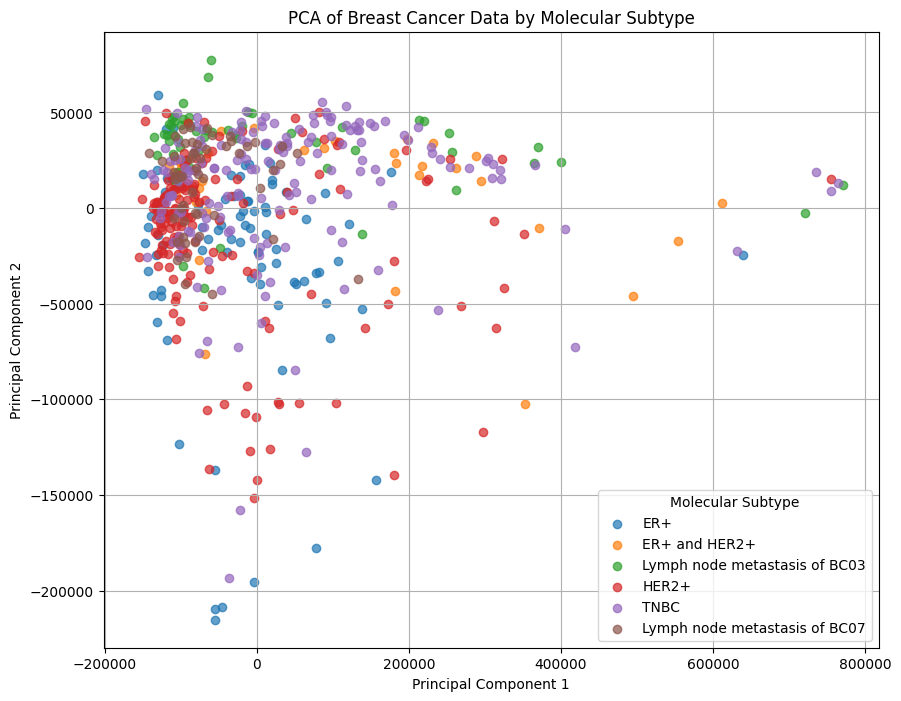

['ER+' 'ER+ and HER2+' 'Lymph node metastasis of BC03' 'HER2+' 'TNBC'
 'Lymph node metastasis of BC07']


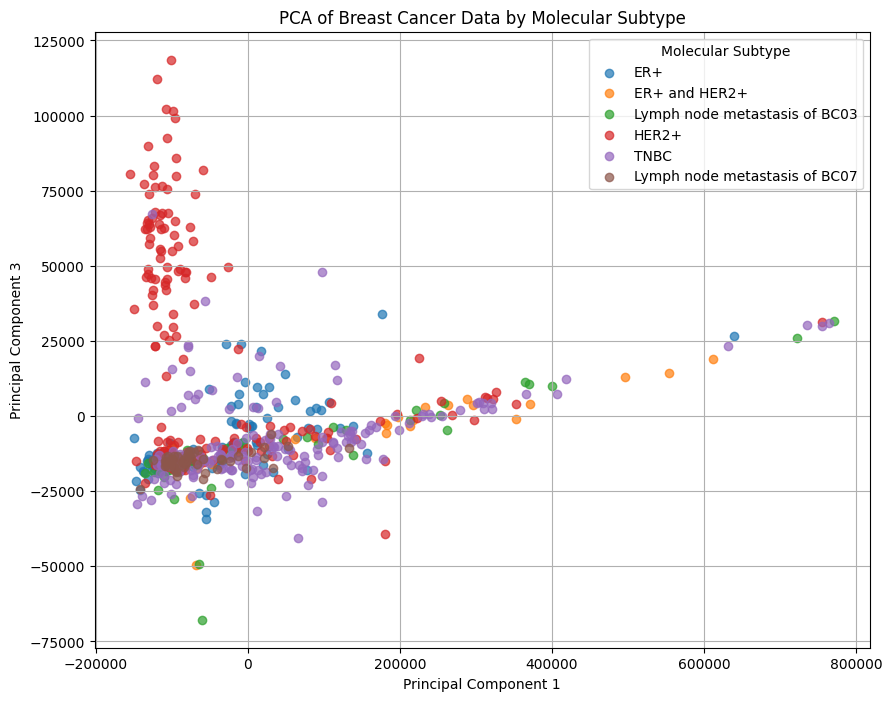

In [14]:
import matplotlib.pyplot as plt
#from sklearn.decomposition import PCA

import pandas as pd
import numpy as np

# Implement PCA Manually as required by the project.
def PCA(X, n_components):
    '''
    PCA takes data matrix X and the number of principal components to return.
    It returns the reduced data matrix after PCA transformation.
    '''
    # Drop the 'Molecular Subtype' column if it exists
    if 'Molecular Subtype' in X.columns:
        X = X.drop('Molecular Subtype', axis=1)

    # Center the data
    X_meaned = X - np.mean(X, axis=0)

    # Can't use the covariance matrix directly because it's memory intensive
    # Instead, use the SVD approach to compute the principal components
    # Perform SVD
    U, S, Vt = np.linalg.svd(X_meaned, full_matrices=False)

    # The principal components are the right singular vectors (Vt)
    principal_components = Vt.T

    # To get the reduced dimension data you can multiply the original, mean centered data with principal components
    X_reduced = np.dot(X_meaned, principal_components)

    return X_reduced[:, :n_components]


# Load the data
file_path = 'data/raw/GSE75688_GEO_processed_Breast_Cancer_raw_TPM_matrix.txt'
df = pd.read_csv(file_path, sep='\t')

# Extract the numerical data
data = df.iloc[:, 3:]

# Transpose the data to have samples in rows
transposed_data = data.T
transposed_data.columns = df['gene_name']

# Create a mapping of sample names to molecular subtypes
subtype_mapping = {
    'BC01': 'ER+', 'BC02': 'ER+',
    'BC03': 'ER+ and HER2+', 'BC03LN': 'Lymph node metastasis of BC03',
    'BC04': 'HER2+', 'BC05': 'HER2+', 'BC06': 'HER2+',
    'BC07': 'TNBC', 'BC08': 'TNBC', 'BC09': 'TNBC', 'BC10': 'TNBC', 'BC11': 'TNBC',
    'BC07LN': 'Lymph node metastasis of BC07'
}

# Extract the sample names from the data
sample_names = transposed_data.index

# Add a new column for molecular subtypes
transposed_data['Molecular Subtype'] = [subtype_mapping.get(name.split('_')[0], 'Unknown') for name in sample_names]
# Perform PCA on the transposed data (without scaling)
principal_components_transposed = PCA(transposed_data, n_components=3)

# Create a DataFrame with the principal components of the transposed data
pca_transposed_df = pd.DataFrame(data=principal_components_transposed, columns=['PC1', 'PC2', 'PC3'])

# Add the 'Molecular Subtype' column to the PCA DataFrame
print(transposed_data['Molecular Subtype'])
print(pca_transposed_df.shape, transposed_data.shape)
transposed_data_copy = transposed_data.reset_index(drop=True)
pca_transposed_df['Molecular Subtype'] = transposed_data_copy['Molecular Subtype']


# Plot the first two principal components with colors based on 'Molecular Subtype'
plt.figure(figsize=(10, 8))
subtypes = pca_transposed_df['Molecular Subtype'].unique()
print(subtypes)
for subtype in subtypes:
    subset = pca_transposed_df[pca_transposed_df['Molecular Subtype'] == subtype]
    plt.scatter(subset['PC1'], subset['PC2'], label=subtype, alpha=0.7)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Breast Cancer Data by Molecular Subtype')
plt.legend(title='Molecular Subtype')
plt.grid(True)
plt.show()

# Plot the first and third principal components with colors based on 'Molecular Subtype'
plt.figure(figsize=(10, 8))
subtypes = pca_transposed_df['Molecular Subtype'].unique()
print(subtypes)
for subtype in subtypes:
    subset = pca_transposed_df[pca_transposed_df['Molecular Subtype'] == subtype]
    plt.scatter(subset['PC1'], subset['PC3'], label=subtype, alpha=0.7)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 3')
plt.title('PCA of Breast Cancer Data by Molecular Subtype')
plt.legend(title='Molecular Subtype')
plt.grid(True)
plt.show()

# Print the explained variance ratio
explained_variance_ratio = np.var(principal_components_transposed, axis=0) / np.sum(np.var(principal_components_transposed, axis=0))
print(explained_variance_ratio)